# Proactive Fraud Detection: End-to-End Modeling, Analysis & Action Plan 

**Author:** Narpat Kumar  

This notebook demonstrates a **fraud detection model** using a transactions dataset with ~6.36M rows and the following columns:

- `step`: 1-hour time steps (`0..743`, 30 days ~ 744 hours)
- `type`: one of `CASH-IN, CASH-OUT, DEBIT, PAYMENT, TRANSFER`
- `amount`: transaction amount
- `nameOrig`: origin account (customer)
- `oldbalanceOrg`, `newbalanceOrig`: origin balances before/after
- `nameDest`: destination account (customer or merchant)
- `oldbalanceDest`, `newbalanceDest`: destination balances before/after *(missing for merchants: names starting with 'M')*
- `isFraud`: label (1 if fraudulent transaction, else 0)
- `isFlaggedFraud`: rule-based flag (1 if attempted transfer > 200,000)

We will follow a complete workflow:

1. **Data Cleaning**: handle duplicates, scan missing values, detect outliers, and address multicollinearity.  
2. **EDA & Visualization**: understand class imbalance, time/amount patterns, and label behavior by `type`.  
3. **Feature Engineering**: construct balance-consistency features and behavioral indicators.  
4. **Dataset Split**: splitting the dataset into dependent and independent variables, followed by training and testing splits.
5. **Modeling**: Logistic Regression and Random Forest with imbalance handling.  
6. **Evaluation**: accuracy, confusion matrix, classification report.
7. **Actionable Plan**: prevention recommendations, infrastructure updates, and post-implementation measurement.  

## 1. Imports

In [1]:
# importing required libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as st
import pylab
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import chi2, SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import warnings
warnings.filterwarnings('ignore')

## 2. Load Data

In [2]:
# loading the dataset as a pandas dataframe
df = pd.read_csv("Fraud.csv")

In [3]:
# dataset shape
print("Shape:", df.shape)

Shape: (6362620, 11)


In [4]:
# first 5 entries
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## 3. Exploratory Data Analysis (EDA)

### 3.1 Sanity Checks and Class Balance

In [5]:
# dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [6]:
# dataset description
pd.set_option('display.float_format', '{:.2f}'.format)
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00,6362620.00
mean,243.40,179861.90,833883.10,855113.67,1100701.67,1224996.40,0.00,0.00
std,142.33,603858.23,2888242.67,2924048.50,3399180.11,3674128.94,0.04,0.00
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,156.00,13389.57,0.00,0.00,0.00,0.00,0.00,0.00
50%,239.00,74871.94,14208.00,0.00,132705.66,214661.44,0.00,0.00
75%,335.00,208721.48,107315.18,144258.41,943036.71,1111909.25,0.00,0.00
max,743.00,92445516.64,59585040.37,49585040.37,356015889.35,356179278.92,1.00,1.00


In [7]:
# description of object dtype columns 
df.describe(include='object')

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1677795071,C1286084959
freq,2237500,3,113


In [8]:
# duplicates check
dup_count = df.duplicated().sum()
print(f"Duplicate rows: {dup_count:,}")

Duplicate rows: 0


In [9]:
# missing values
df.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [10]:
# number of unique values
df.nunique()

step                  743
type                    5
amount            5316900
nameOrig          6353307
oldbalanceOrg     1845844
newbalanceOrig    2682586
nameDest          2722362
oldbalanceDest    3614697
newbalanceDest    3555499
isFraud                 2
isFlaggedFraud          2
dtype: int64

In [11]:
# class balance
fraud_rate = df["isFraud"].mean()
print(f"\nFraud rate: {fraud_rate*100:.4f}%  ({df['isFraud'].sum():,} / {len(df):,})")


Fraud rate: 0.1291%  (8,213 / 6,362,620)


In [12]:
# distribution of transaction types
type_counts = df["type"].value_counts().sort_index()
type_counts

type
CASH_IN     1399284
CASH_OUT    2237500
DEBIT         41432
PAYMENT     2151495
TRANSFER     532909
Name: count, dtype: int64

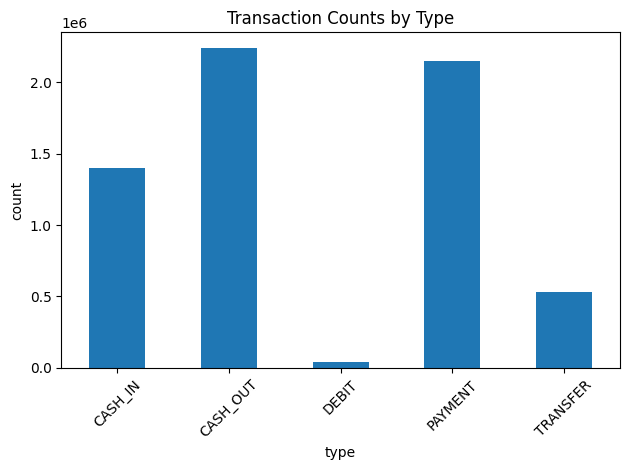

In [13]:
# plotting type distribution
fig, ax = plt.subplots()
type_counts.plot(kind="bar", ax=ax, rot=45)
ax.set_title("Transaction Counts by Type")
ax.set_xlabel("type")
ax.set_ylabel("count")
plt.tight_layout()
plt.show()

In [14]:
# distribution of fraud by type
fraud_by_type = df.groupby("type")["isFraud"].mean().sort_index()
(fraud_by_type*100).round(4)

type
CASH_IN    0.00
CASH_OUT   0.18
DEBIT      0.00
PAYMENT    0.00
TRANSFER   0.77
Name: isFraud, dtype: float64

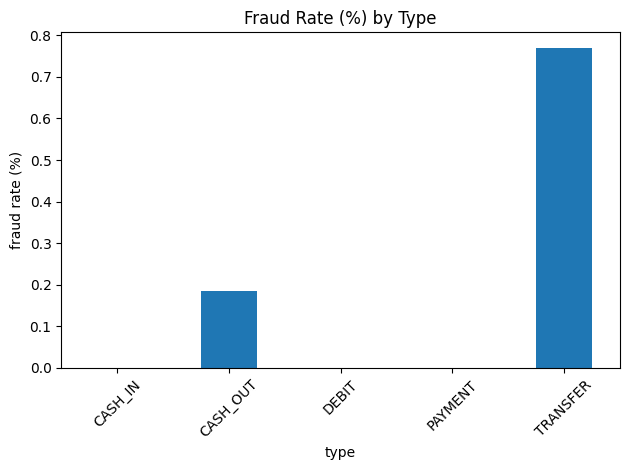

In [15]:
# plotting fraud rate by type
fig, ax = plt.subplots()
(fraud_by_type*100).plot(kind="bar", ax=ax, rot=45)
ax.set_title("Fraud Rate (%) by Type")
ax.set_xlabel("type")
ax.set_ylabel("fraud rate (%)")
plt.tight_layout()
plt.show()

In [16]:
# steps coverage
print("Step range:", int(df["step"].min()), "to", int(df["step"].max()))

Step range: 1 to 743


### 3.2 Time and Amount Distributions

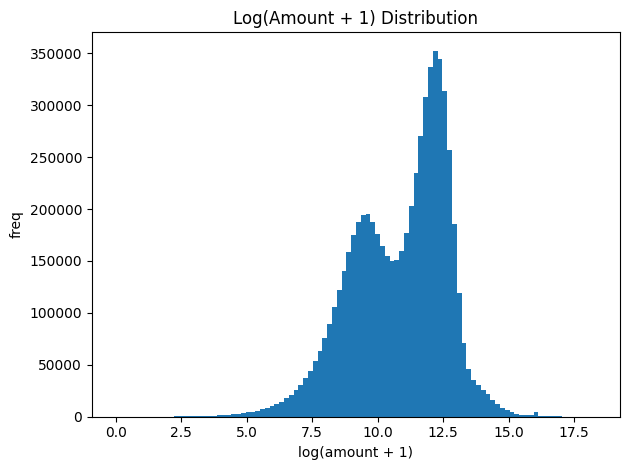

In [17]:
# amount distribution (log)
amt_sample = df["amount"]
log_amt = np.log1p(amt_sample.values)

fig, ax = plt.subplots()
ax.hist(log_amt, bins=100)
ax.set_title("Log(Amount + 1) Distribution")
ax.set_xlabel("log(amount + 1)")
ax.set_ylabel("freq")
plt.tight_layout()
plt.show()

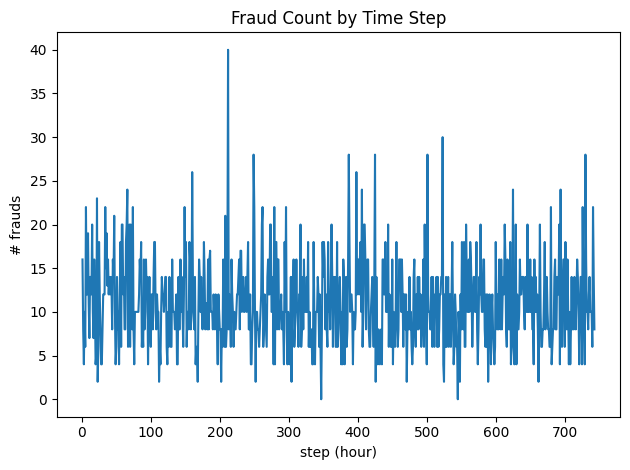

In [18]:
# fraud counts over time
fraud_counts_by_step = df.groupby("step")["isFraud"].sum()
fig, ax = plt.subplots()
ax.plot(fraud_counts_by_step.index, fraud_counts_by_step.values)
ax.set_title("Fraud Count by Time Step")
ax.set_xlabel("step (hour)")
ax.set_ylabel("# frauds")
plt.tight_layout()
plt.show()

### 3.3 Correlation and Heatmap

In [19]:
# dataset correlation
corr = df[df.select_dtypes(include=['number']).columns.tolist()].corr()
corr

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.00,0.02,-0.01,-0.01,0.03,0.03,0.03,0.00
amount,0.02,1.00,-0.00,-0.01,0.29,0.46,0.08,0.01
oldbalanceOrg,-0.01,-0.00,1.00,1.00,0.07,0.04,0.01,0.00
newbalanceOrig,-0.01,-0.01,1.00,1.00,0.07,0.04,-0.01,0.00
oldbalanceDest,0.03,0.29,0.07,0.07,1.00,0.98,-0.01,-0.00
newbalanceDest,0.03,0.46,0.04,0.04,0.98,1.00,0.00,-0.00
isFraud,0.03,0.08,0.01,-0.01,-0.01,0.00,1.00,0.04
isFlaggedFraud,0.00,0.01,0.00,0.00,-0.00,-0.00,0.04,1.00


<Axes: >

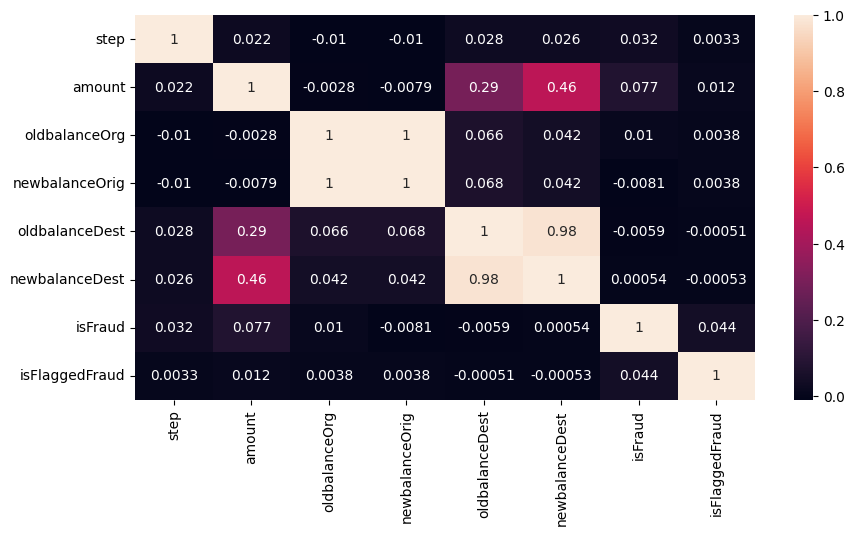

In [20]:
# correlation heatmap
plt.figure(figsize=(10,5))
sns.heatmap(corr,annot=True)

## 4. Feature engineering

### 4.1 Label Encoding

In [21]:
# label encoding
encoder = {}
for i in df.select_dtypes('object').columns:
    encoder[i] = LabelEncoder()
    df[i] = encoder[i].fit_transform(df[i])

In [22]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,3,9839.64,757869,170136.00,160296.36,1662094,0.00,0.00,0,0
1,1,3,1864.28,2188998,21249.00,19384.72,1733924,0.00,0.00,0,0
2,1,4,181.00,1002156,181.00,0.00,439685,0.00,0.00,1,0
3,1,1,181.00,5828262,181.00,0.00,391696,21182.00,0.00,1,0
4,1,3,11668.14,3445981,41554.00,29885.86,828919,0.00,0.00,0,0


### 4.2 Balance-consistency features

In [23]:
# these check whether balances before & after the transaction are consistent.
df["orig_diff"] = df["oldbalanceOrg"] - df["amount"] - df["newbalanceOrig"]
df["dest_diff"] = df["oldbalanceDest"] + df["amount"] - df["newbalanceDest"]

### 4.3 Boolean mismatch flags

In [24]:
# mark if the above balance equations don’t hold (tolerating floating point error).
eps = 1e-3  # small threshold to account for rounding issues
df["orig_mismatch"] = (df["orig_diff"].abs() > eps).astype("int8")
df["dest_mismatch"] = (df["dest_diff"].abs() > eps).astype("int8")

### 4.4 Ratio Features

In [25]:
# transaction amount relative to sender’s original balance.
# Useful because frauds often involve draining most/all of the balance.
df["amt_over_oldOrig"] = df["amount"] / (df["oldbalanceOrg"].abs() + 1.0)
# +1 prevents division by zero.

### 4.5 Zero-balance indicators

In [26]:
# fraud patterns sometimes involve accounts with zero balances before/after.
for col in ["oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]:
    df[f"zero_{col}"] = (df[col].abs() < eps).astype("int8")

### 4.6 Destination type flags

In [27]:
# merchant accounts often start with "M", customer accounts with "C".
# These help the model distinguish transaction flows.
df["dest_is_merchant"] = df["nameDest"].astype(str).str.startswith("M").astype("int8")
df["dest_is_customer"] = 1 - df["dest_is_merchant"]

In [28]:
# dataframe head
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,...,dest_diff,orig_mismatch,dest_mismatch,amt_over_oldOrig,zero_oldbalanceOrg,zero_newbalanceOrig,zero_oldbalanceDest,zero_newbalanceDest,dest_is_merchant,dest_is_customer
0,1,3,9839.64,757869,170136.00,160296.36,1662094,0.00,0.00,0,...,9839.64,0,1,0.06,0,0,1,1,0,1
1,1,3,1864.28,2188998,21249.00,19384.72,1733924,0.00,0.00,0,...,1864.28,0,1,0.09,0,0,1,1,0,1
2,1,4,181.00,1002156,181.00,0.00,439685,0.00,0.00,1,...,181.00,0,1,0.99,0,1,1,1,0,1
3,1,1,181.00,5828262,181.00,0.00,391696,21182.00,0.00,1,...,21363.00,0,1,0.99,0,1,0,1,0,1
4,1,3,11668.14,3445981,41554.00,29885.86,828919,0.00,0.00,0,...,11668.14,0,1,0.28,0,0,1,1,0,1


In [29]:
# how often do mismatches occur by transaction type?
mismatch_by_type = df.groupby("type")[["orig_mismatch", "dest_mismatch"]].mean()
print("\nMismatch rates by type (mean mismatch rate):\n", mismatch_by_type)


Mismatch rates by type (mean mismatch rate):
       orig_mismatch  dest_mismatch
type                              
0              1.00           1.00
1              0.89           0.29
2              0.31           0.31
3              0.56           1.00
4              0.96           0.30


## 5. Dependent (Target) and Independent features

In [30]:
# dividing the df into X (independent) and y (target)
X = df.drop(columns=['isFraud'])
y = df['isFraud']

In [31]:
# checking the class balance (again)
y.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

#### Handling Class Imbalance using SMOTE

In [32]:
# initializing SMOTE oversampler
over_sample = SMOTE(random_state=0)

In [33]:
# applying SMOTE to balance the dataset
# X, y = over_sample.fit_resample(X, y)

### Handling Imbalanced Data

During experimentation with **SMOTE oversampling**, a `MemoryError` occurred because the dataset is very large (over 6 million records).  
SMOTE generates synthetic samples in memory, which caused the RAM usage to exceed system capacity.

To address this limitation, instead of oversampling, we will proceed by using the **`class_weight='balanced'`** parameter available in certain machine learning models.  

This approach adjusts the loss function to penalize misclassification of minority classes more heavily, effectively handling class imbalance **without creating additional data in memory**.

## 6. Train and Test Split

In [34]:
# train and test split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=0)

## 7. Feature Scaling

In [35]:
# MinMaxScaler object
scaler = MinMaxScaler()

In [36]:
# scaling train and test splits
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## 8. Modeling

We fit two strong baselines:

1. **Logistic Regression** (linear, interpretable coefficients; `class_weight='balanced'`)
2. **Random Forest** (nonlinear, robust to feature scaling; with `class_weight='balanced_subsample'`)

### 8.1 Logistic Regression

#### 8.1.1 Modeling

In [37]:
# logistic regression
log_reg = LogisticRegression(class_weight='balanced')

# cross-validation on training set
cv_scores = cross_val_score(log_reg, X_train, y_train, cv=3, scoring='accuracy')  
print("CV Accuracy:", cv_scores)
print("Mean CV Accuracy:", cv_scores.mean())

CV Accuracy: [0.99978782 0.99972922 0.99975145]
Mean CV Accuracy: 0.9997561651306137


In [38]:
# model fitting and predictions
log_reg.fit(X_train, y_train)
y_pred = log_reg.predict(X_test)

#### 8.1.2 Model Evaluation

In [39]:
# accuracy score
accuracy_score(y_test,y_pred)

0.9997108109552354

In [40]:
# confusion matrix
confusion_matrix(y_test,y_pred)

array([[1905822,     545],
       [      7,    2412]])

In [41]:
# classification report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       0.82      1.00      0.90      2419

    accuracy                           1.00   1908786
   macro avg       0.91      1.00      0.95   1908786
weighted avg       1.00      1.00      1.00   1908786



#### 8.1.3 Selecting the Best Features

In [42]:
# feature selection
chi_best_col = SelectKBest(chi2,k=8)
kbest = chi_best_col.fit_transform(X_train,y_train)
np.array(df.drop(columns=['isFraud']).columns)[chi_best_col.get_support()]

array(['type', 'amount', 'nameDest', 'isFlaggedFraud', 'orig_mismatch',
       'zero_oldbalanceOrg', 'zero_newbalanceOrig', 'zero_oldbalanceDest'],
      dtype=object)

In [43]:
# feature scores
pd.DataFrame(list(zip(df.drop(columns=['isFraud']).columns,chi_best_col.scores_)),columns=['features','scores']).sort_values(by='scores',ascending=False)

,features,scores
9,isFlaggedFraud,7676.98
12,orig_mismatch,4610.40
15,zero_oldbalanceOrg,1855.40
16,zero_newbalanceOrig,1759.53
2,amount,714.41
17,zero_oldbalanceDest,708.21
6,nameDest,598.36
1,type,509.26
0,step,464.90
18,zero_newbalanceDest,192.79


#### 8.1.4 Logistic Regression on the Best Features

In [47]:
# feature selection on X and y
X1 = df[['type', 'amount', 'nameDest', 'isFlaggedFraud', 'orig_mismatch',
       'zero_oldbalanceOrg', 'zero_newbalanceOrig', 'zero_oldbalanceDest']]
y1 = df['isFraud']

# train test split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.30,random_state=0)

# logistic regression
log_reg1 = LogisticRegression(class_weight='balanced')

# cross-validation on training set
cv_scores1 = cross_val_score(log_reg1, X1_train, y1_train, cv=3, scoring='accuracy')  
print("CV Accuracy:", cv_scores1)
print("Mean CV Accuracy:", cv_scores1.mean())

CV Accuracy: [0.97742643 0.97800434 0.97716169]
Mean CV Accuracy: 0.9775308195375927


In [48]:
# model fitting and predictions
log_reg1.fit(X1_train, y1_train)
y1_pred = log_reg1.predict(X1_test)

In [49]:
# evaluation

# accuracy score
print(accuracy_score(y1_test,y1_pred))
print('\n')

# confusion matrix
print(confusion_matrix(y1_test,y1_pred))
print('\n')

# classification report
print(classification_report(y1_test,y1_pred))

0.9774359200036044


[[1863319   43048]
 [     22    2397]]


              precision    recall  f1-score   support

           0       1.00      0.98      0.99   1906367
           1       0.05      0.99      0.10      2419

    accuracy                           0.98   1908786
   macro avg       0.53      0.98      0.54   1908786
weighted avg       1.00      0.98      0.99   1908786



### 8.2 Random Forest Classifier

Since we have selected the **best feature** using `SelectKBest`, we don't need to re-do the feature selection again.

We directly use those selected features `X1_train` and `X1_test` for training our **Random Forest Classifier**

In [50]:
# random forest classification
random_clf = RandomForestClassifier(
    n_estimators=100,
    max_depth=16,
    max_features='sqrt',
    min_samples_leaf=5,
    class_weight='balanced',
    n_jobs=-1,
    oob_score=True,
    random_state=42
)

# model fitting
random_clf.fit(X1_train, y1_train)

,n_estimators,100
,criterion,'gini'
,max_depth,16
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,True


In [51]:
# OOB score
print("OOB Score: ", random_clf.oob_score_)

OOB Score:  0.9999939378072914


In [52]:
# prediction
y_pred_rf = random_clf.predict(X1_test)

In [53]:
# evaluation

# accuracy score
print(accuracy_score(y1_test,y_pred_rf))
print('\n')

# confusion matrix
print(confusion_matrix(y1_test,y_pred_rf))
print('\n')

# classification report
print(classification_report(y1_test,y_pred_rf))

0.9999958088544237


[[1906367       0]
 [      8    2411]]


              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906367
           1       1.00      1.00      1.00      2419

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



## 9. Actionable Prevention Plan (Infrastructure & Process)

**Controls to implement:**
- **Strong authentication for risky transactions**: Ask extra verification for `CASH_OUT` and `TRANSFER` above certain amounts.
- **Limits on transaction speed/volume**: Restrict how many or how large transactions a user can do in an hour/day; pause activity if unusual bursts occur.
- **Balance consistency checks**: Flag or block transactions where `orig_diff` or `dest_diff` are suspicious.
- **Merchant risk monitoring**: Watch new or high-risk merchants (destinations starting with `M`) more closely.
- **Device and session monitoring**: Check device, location, and behavior; trigger alerts if unusual.
- **Two-step fraud defense**: (1) Hard rules for immediate blocking, (2) ML model score to send suspicious cases for manual review.
- **Continuous learning**: Feed confirmed fraud or legitimate transactions back to retrain models and adjust rules weekly.

**Data/Model Operations:**
- **Regular retraining**: Update the model weekly and monitor changes in feature distributions.
- **Threshold management**: Keep safety thresholds for catching fraud and adjust for business goals.
- **Explainability dashboards**: Track which features are driving predictions and monitor any changes over time.
